# Створення нейронної мережі

У цьому завданні ми створимо повнозв'язну нейронну мережу, використовуючи при цьому низькорівневі механізми tensorflow.

Архітектура нейромережі представлена на наступному малюнку. Як бачиш, у ній є один вхідний шар, два приховані, а також вихідний шар. В якості активаційної функції у прихованих шарах буде використовуватись сигмоїда. На вихідному шарі ми використовуємо softmax.

Частина коду зі створення мережі вже написана, тобі потрібно заповнити пропуски у вказаних місцях.

## Архітектура нейронної мережі

<img src="http://cs231n.github.io/assets/nn1/neural_net2.jpeg" alt="nn" style="width: 400px;"/>


## Про датасет MNIST

Дану нейромережу ми будемо вивчати на датасеті MNIST. Цей датасет являє собою велику кількість зображень рукописних цифр розміром $28 \times 28$ пікселів. Кожен піксель приймає значення від 0 до 255.

Як і раніше, датасет буде розділений на навчальну та тестову вибірки. При цьому ми виконаємо нормалізацію всіх зображень, щоб значення пікселів знаходилось у проміжку від 0 до 1, розділивши яскравість кожного пікселя на 255.

Окрім того, архітектура нейронної мережі очікує на вхід вектор. У нашому ж випадку кожен об'єкт вибірки являє собою матрицю. Що ж робити? У цьому завданні ми "розтягнемо" матрицю $28 \times 28$, отримавши при цьому вектор, що складається з 784 елементів.

![MNIST Dataset](https://www.researchgate.net/profile/Steven-Young-5/publication/306056875/figure/fig1/AS:393921575309346@1470929630835/Example-images-from-the-MNIST-dataset.png)

Більше інформації про датасет можна знайти [тут](http://yann.lecun.com/exdb/mnist/).

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import keras as K
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [2]:
num_classes = 10 
num_features = 784 

learning_rate = 0.001
training_steps = 3000 
batch_size = 256 
display_step = 100

n_hidden_1 = 128 
n_hidden_2 = 256 

In [3]:
from keras.datasets import mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train, x_test = np.array(x_train, np.float32), np.array(x_test, np.float32)

x_train, x_test = x_train.reshape([-1, num_features]), x_test.reshape([-1, num_features])

x_train, x_test = x_train / 255., x_test / 255.

train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.repeat().shuffle(5000).batch(batch_size).prefetch(1)

In [4]:
class DenseLayer(tf.Module):
    def __init__(self, in_features, out_features, name=None):
        super().__init__(name=name)
        self.w = tf.Variable(
            tf.random.normal([in_features, out_features]), name="w"
        )
        self.b = tf.Variable(tf.zeros([out_features]), name="b")

    def __call__(self, x, activation=0):
        y = tf.matmul(x, self.w) + self.b
        if activation != 0:
            return tf.nn.softmax(y)
        else:
            return tf.nn.sigmoid(y)

class NN(tf.Module):
  def __init__(self, name=None):
    super().__init__(name=name)
    self.w1 = tf.Variable(tf.random.normal([num_features, 128]), name='w1')
    self.b1 = tf.Variable(tf.zeros([128]), name='b1')

    self.w2 = tf.Variable(tf.random.normal([128, 256]), name='w2')
    self.b2 = tf.Variable(tf.zeros([256]), name='b2')

    self.w3 = tf.Variable(tf.random.normal([256, 10]), name='w3')
    self.b3 = tf.Variable(tf.zeros([10]), name='b3')


  def __call__(self, x):
      x = tf.matmul(x, self.w1) + self.b1
      x = tf.nn.relu(x)
      x = tf.matmul(x, self.w2) + self.b2
      x = tf.nn.relu(x)
      x = tf.matmul(x, self.w3) + self.b3

      return tf.nn.softmax(x)

In [5]:
def cross_entropy(y_pred, y_true):
    y_true = tf.one_hot(y_true, depth=num_classes)
    y_pred = tf.clip_by_value(y_pred, 1e-9, 1.)
    return tf.reduce_mean(-tf.reduce_sum(y_true * tf.math.log(y_pred)))

def accuracy(y_pred, y_true):
    y_pred_classes = tf.argmax(y_pred, axis=1)
    y_true = tf.cast(y_true, tf.int64)
    accuracy_value = tf.reduce_mean(tf.cast(y_pred_classes == y_true, tf.float32))

    return accuracy_value

In [6]:
neural_net = NN(name="mnist")

def train(neural_net, input_x, output_y, learning_rate=0.01):
  optimizer = tf.optimizers.SGD(learning_rate)

  with tf.GradientTape() as g:
    pred = neural_net(input_x)
    loss = cross_entropy(pred, output_y)

  trainable_variables = neural_net.trainable_variables
  gradients = g.gradient(loss, trainable_variables)
  optimizer.apply_gradients(zip(gradients, trainable_variables))

  return loss

In [7]:
loss_history = []  
accuracy_history = [] 

for step, (batch_x, batch_y) in enumerate(train_data.take(training_steps), 1):
    batch_x = tf.reshape(batch_x, (-1, 784))

    loss = train(neural_net, batch_x, batch_y, learning_rate=0.01)

    if step % display_step == 0:
        pred = neural_net(batch_x)
        loss_value = cross_entropy(pred, batch_y)  
        accuracy_value = accuracy(pred, batch_y)  
        loss_history.append(loss_value.numpy())
        accuracy_history.append(accuracy_value.numpy())

        print(f"Step {step}, Loss: {loss_value.numpy():.4f}, Accuracy: {accuracy_value.numpy():.4%}")



Step 100, Loss: 4745.6279, Accuracy: 10.5469%
Step 200, Loss: 4828.5205, Accuracy: 8.9844%
Step 300, Loss: 4766.3506, Accuracy: 10.1562%
Step 400, Loss: 4849.2441, Accuracy: 8.5938%
Step 500, Loss: 4704.1807, Accuracy: 11.3281%
Step 600, Loss: 4828.5205, Accuracy: 8.9844%
Step 700, Loss: 4869.9668, Accuracy: 8.2031%
Step 800, Loss: 4766.3506, Accuracy: 10.1562%
Step 900, Loss: 4642.0112, Accuracy: 12.5000%
Step 1000, Loss: 4807.7974, Accuracy: 9.3750%
Step 1100, Loss: 4642.0112, Accuracy: 12.5000%
Step 1200, Loss: 4890.6904, Accuracy: 7.8125%
Step 1300, Loss: 4828.5205, Accuracy: 8.9844%
Step 1400, Loss: 4683.4580, Accuracy: 11.7188%
Step 1500, Loss: 4869.9673, Accuracy: 8.2031%
Step 1600, Loss: 4662.7344, Accuracy: 12.1094%
Step 1700, Loss: 4559.1182, Accuracy: 14.0625%
Step 1800, Loss: 4704.1807, Accuracy: 11.3281%
Step 1900, Loss: 4724.9043, Accuracy: 10.9375%
Step 2000, Loss: 4952.8604, Accuracy: 6.6406%
Step 2100, Loss: 4828.5205, Accuracy: 8.9844%
Step 2200, Loss: 4869.9673, Accu

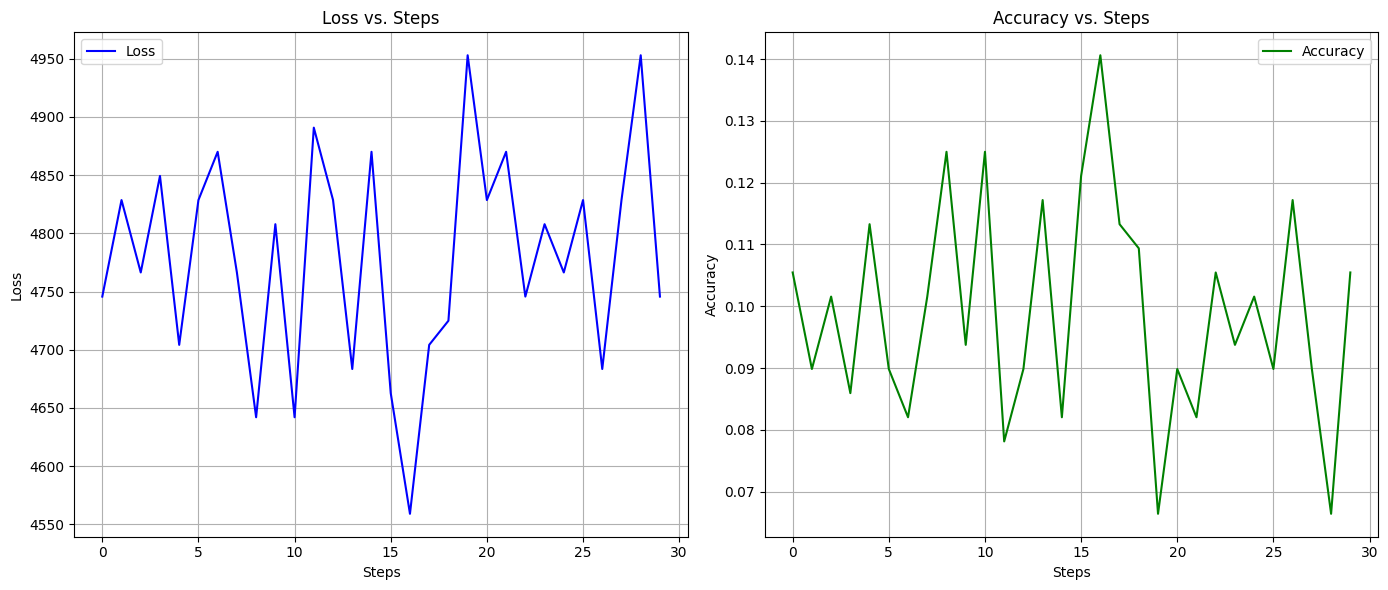

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)  
plt.plot(loss_history, label='Loss', color='blue')
plt.title('Loss vs. Steps')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.grid()
plt.legend()

plt.subplot(1, 2, 2) 
plt.plot(accuracy_history, label='Accuracy', color='green')
plt.title('Accuracy vs. Steps')
plt.xlabel('Steps')
plt.ylabel('Accuracy')
plt.grid()
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
train_accuracy_values = []

for batch_x, batch_y in train_data:
    pred = neural_net(batch_x)  
    train_accuracy_values.append(accuracy(pred, batch_y).numpy())  

average_train_accuracy = np.mean(train_accuracy_values)
print(f"Точність на тренувальних даних: {average_train_accuracy:.4%}")


In [ ]:
test_images, test_labels = next(iter(test_data.shuffle(buffer_size=10000).take(5)))

predictions = neural_net(test_images)

plt.figure(figsize=(15, 5))

incorrect_count = 0

for i in range(len(test_images)):
    plt.subplot(2, 5, i + 1)
    plt.imshow(test_images[i].numpy().reshape(28, 28), cmap='gray')
    plt.axis('off')
    predicted_class = tf.argmax(predictions[i]).numpy()
    true_class = test_labels[i].numpy()
    plt.title(f'True: {true_class}, Pred: {predicted_class}')
    
    if predicted_class != true_class:
        incorrect_count += 1

plt.show()

error_rate = incorrect_count / len(test_images)
print(f"Кількість помилок: {incorrect_count} з {len(test_images)} зображень.")
print(f"Частота помилок: {error_rate:.2%}")

